In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.AllChem import GetBestRMS
from rdkit import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

import os
import gemmi
import pandas as pd
import csv
from pymol import cmd

In [36]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [7]:
IPythonConsole.drawOptions.addAtomIndices = True

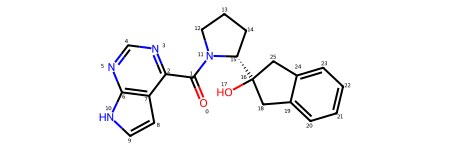

In [34]:
tmplt_smiles = "O=C(C1=NC=NC2=C1C=CN2)N1CCC[C@@H]1C1(O)CC2=CC=CC=C2C1"
tmplt_mol = Chem.MolFromSmiles(tmplt_smiles)
tmplt_mol

In [35]:
# Load ligands
reference = Chem.MolFromPDBFile("/Users/JB/Rotation_bkslab/250203_alphafold3/PDBS_lig/mac-x5131.pdb", removeHs=False)
predicted = Chem.MolFromPDBFile("/Users/JB/Rotation_bkslab/Mac1_docked_poses/aligned_ligands_dock/mac-x5131.pdb", removeHs=False)

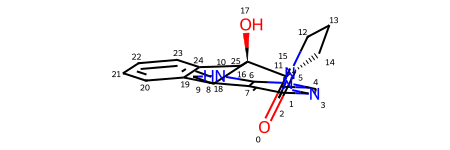

In [45]:
reference = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, reference)
reference.__sssAtoms = []
reference

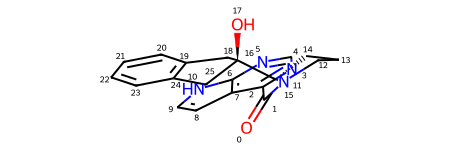

In [46]:
predicted = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, predicted)
predicted.__sssAtoms = []
predicted

In [48]:
# Align and calculate RMSD
AllChem.AlignMol(predicted, reference)
rmsd = AllChem.GetBestRMS(reference, predicted)
print(f"RMSD: {rmsd:.3f} Å")

RMSD: 0.673 Å


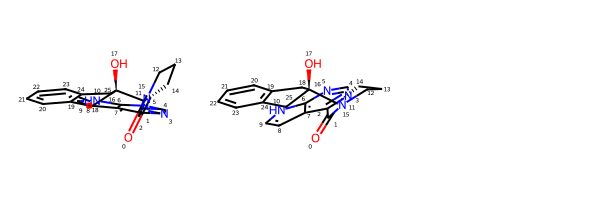

In [49]:
MolsToGridImage([reference, predicted])

Use substructure search to get a mapping between **ref_pdb_mol** and **model_pdb_mol**

In [50]:
match_list = predicted.GetSubstructMatches(reference)[0]

In [41]:
match_list

(2,
 0,
 3,
 1,
 6,
 4,
 8,
 10,
 11,
 12,
 7,
 9,
 13,
 14,
 15,
 16,
 17,
 5,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18)

Renumber **model_pdb_mol** to match **ref_pdb_mol**

In [42]:
predicted = Chem.RenumberAtoms(predicted,match_list)

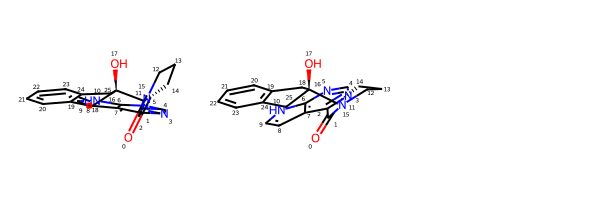

In [43]:
MolsToGridImage([reference,predicted])

In [ ]:
#####Running ligand RMSD + sanity check included from posebuster paper######

In [33]:
import os
import csv
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True

excel_file = "/Users/JB/Rotation_bkslab/250203_alphafold3/20241209_mac1.xlsx"
ref_dir = "/Users/JB/Rotation_bkslab/250203_alphafold3/PDBS_lig"
pred_dir = "/Users/JB/Rotation_bkslab/Mac1_docked_poses/aligned_ligands_dock"
output_csv = "/Users/JB/Rotation_bkslab/Mac1_docked_poses/docked_L-RMSD.csv"

df = pd.read_excel(excel_file)
df['Dataset_ID'] = df['Dataset_ID'].astype(str)
df['SMILES'] = df['SMILES'].astype(str)

rmsd_results = []

# Loop through reference files
for ref_file in os.listdir(ref_dir):
    if not ref_file.endswith(".pdb"):
        continue

    # Extract the prefix
    ref_prefix = os.path.splitext(ref_file)[0]

    # Find the corresponding predicted file
    pred_file = f"{ref_prefix}.pdb"
    pred_path = os.path.join(pred_dir, pred_file)
    ref_path = os.path.join(ref_dir, ref_file)

    if not os.path.exists(pred_path):
        print(f"[WARNING] Predicted file not found for {ref_prefix}. Skipping.")
        continue

    # Retrieve SMILES from the Excel file
    tmplt_smiles_row = df.loc[df['Dataset_ID'] == ref_prefix, 'SMILES']
    if tmplt_smiles_row.empty or pd.isna(tmplt_smiles_row.values[0]):
        print(f"[WARNING] No SMILES found for {ref_prefix}. Skipping.")
        continue
    tmplt_smiles = str(tmplt_smiles_row.values[0])

    # Convert the SMILES to an RDKit molecule
    tmplt_mol = Chem.MolFromSmiles(tmplt_smiles)
    if not tmplt_mol:
        print(f"[ERROR] Invalid SMILES for {ref_prefix}: {tmplt_smiles}. Skipping.")
        continue

    # Load reference and predicted structures
    reference = Chem.MolFromPDBFile(ref_path, removeHs=False)
    predicted = Chem.MolFromPDBFile(pred_path, removeHs=False)

    if not reference or not predicted:
        print(f"[ERROR] Failed to load structures for {ref_prefix}. Skipping.")
        continue

    # Assign bond orders
    try:
        reference = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, reference)
        predicted = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, predicted)
    except Exception as e:
        print(f"[ERROR] Bond order assignment failed for {ref_prefix}: {e}")
        continue

    # Perform substructure matching and renumber atoms
    matches = predicted.GetSubstructMatches(reference)
    if not matches:
        print(f"[ERROR] No substructure matches found for {ref_prefix}. Skipping.")
        continue
    match_list = matches[0]
    predicted = Chem.RenumberAtoms(predicted, match_list)

    # Display molecular structures
    Draw.MolsToGridImage([reference, predicted], legends=["Reference", "Predicted"], molsPerRow=2)

    # Find RMSD
    try:
        rmsd = AllChem.GetBestRMS(reference, predicted)
        print(f"RMSD for {ref_prefix}: {rmsd:.3f} Å")
        rmsd_results.append([ref_prefix, rmsd])
    except Exception as e:
        print(f"[ERROR] RMSD calculation failed for {ref_prefix}: {e}")
        continue

# Write RMSD results to a CSV file
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID", "RMSD"])
    writer.writerows(rmsd_results)

print(f"[INFO] RMSD results saved to {output_csv}")

[WARNING] Predicted file not found for mac-x4236_pred_chain. Skipping.
RMSD for mac-x5327: 1.557 Å
[WARNING] Predicted file not found for mac-x5516_pred_chain. Skipping.
RMSD for mac-x4788: 1.994 Å
[WARNING] Predicted file not found for mac-x4856_pred_chain. Skipping.
RMSD for mac-x5119: 1.000 Å
[WARNING] Predicted file not found for mac-x4734_pred_chain. Skipping.
RMSD for mac-x5657: 0.860 Å
RMSD for mac-x5131: 0.673 Å
[WARNING] Predicted file not found for mac-x5400_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5415_pred_chain. Skipping.
RMSD for mac-x3597: 1.470 Å
[WARNING] Predicted file not found for mac-x5001_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3473_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4940_pred_chain. Skipping.
RMSD for mac-x4373: 1.885 Å
[WARNING] Predicted file not found for mac-x3928_pred_chain. Skipping.
RMSD for mac-x3408: 1.764 Å
RMSD for mac-x5079: 0.408 Å
RMSD for mac-x3420: 1.587 Å
RMSD for m

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picki

RMSD for mac-x5087: 1.787 Å
RMSD for mac-x5093: 1.938 Å
RMSD for mac-x3421: 1.053 Å
RMSD for mac-x5078: 2.151 Å
RMSD for mac-x3409: 1.090 Å
RMSD for mac-x4372: 1.662 Å
RMSD for mac-x5681: 0.388 Å
[WARNING] Predicted file not found for mac-x4948_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5655_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5640_pred_chain. Skipping.
RMSD for mac-x5656: 1.748 Å
RMSD for mac-x3555: 0.897 Å
[WARNING] Predicted file not found for mac-x4160_pred_chain. Skipping.
RMSD for mac-x5124: 0.614 Å
RMSD for mac-x5642: 0.925 Å
[WARNING] Predicted file not found for mac-x5191_pred_chain. Skipping.
[ERROR] Invalid SMILES for mac-x3233: nan. Skipping.
RMSD for mac-x5118: 1.910 Å
RMSD for mac-x4951: 2.145 Å
[WARNING] Predicted file not found for mac-x5357_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5342_pred_chain. Skipping.
RMSD for mac-x5332: 1.920 Å
[WARNING] Predicted file not found for mac-x5087_pred_chai

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] SMILES Parse Error: syntax error while parsing: nan
[23:22:08] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[23:22:08] WARNING: More than one matching pattern found - picking on

RMSD for mac-x5085: 0.875 Å
[WARNING] Predicted file not found for mac-x4757_pred_chain. Skipping.
RMSD for mac-x5091: 0.438 Å
RMSD for mac-x4166: 0.847 Å
[WARNING] Predicted file not found for mac-x4820_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4835_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5560_pred_chain. Skipping.
RMSD for mac-x5244: 1.470 Å
[WARNING] Predicted file not found for mac-x4240_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4008_pred_chain. Skipping.
RMSD for mac-x4827: 1.783 Å
RMSD for mac-x4833: 2.464 Å
RMSD for mac-x5292: 0.529 Å
[WARNING] Predicted file not found for mac-x3932_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3927_pred_chain. Skipping.
RMSD for mac-x4826: 0.776 Å
RMSD for mac-x5251: 1.061 Å
RMSD for mac-x5523: 0.621 Å
[WARNING] Predicted file not found for mac-x5720_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5169_pred_chain. Skipping.
[WARNING] 

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picki

RMSD for mac-x4013: 1.191 Å
RMSD for mac-x5335: 2.062 Å
RMSD for mac-x4995: 2.643 Å
RMSD for mac-x5453: 1.943 Å
RMSD for mac-x4981: 2.038 Å
[WARNING] Predicted file not found for mac-x3419_pred_chain. Skipping.
RMSD for mac-x4759: 1.221 Å
[ERROR] Bond order assignment failed for mac-x3988: No matching found
RMSD for mac-x4771: 1.931 Å
RMSD for mac-x4765: 1.200 Å
[WARNING] Predicted file not found for mac-x5637_pred_chain. Skipping.
RMSD for mac-x5490: 0.829 Å
[WARNING] Predicted file not found for mac-x4102_pred_chain. Skipping.
RMSD for mac-x4942: 1.660 Å
RMSD for mac-x3963: 0.214 Å
RMSD for mac-x5651: 1.594 Å
RMSD for mac-x5123: 1.946 Å
[WARNING] Predicted file not found for mac-x4829_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5335_pred_chain. Skipping.
RMSD for mac-x5645: 1.779 Å
RMSD for mac-x4201: 0.767 Å
[WARNING] Predicted file not found for mac-x5734_pred_chain. Skipping.
RMSD for mac-x5679: 0.666 Å
[WARNING] Predicted file not found for mac-x4014_pred_ch

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picking one

[23:22:08] WARNING: More than one matching pattern found - picki

RMSD for mac-x5282: 0.730 Å
[WARNING] Predicted file not found for mac-x5081_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3942_pred_chain. Skipping.
RMSD for mac-x4837: 1.048 Å
RMSD for mac-x5297: 1.739 Å
[WARNING] Predicted file not found for mac-x5758_pred_chain. Skipping.
RMSD for mac-x4162: 1.659 Å
[WARNING] Predicted file not found for mac-x5510_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5505_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4850_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5359_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4727_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4732_pred_chain. Skipping.
RMSD for mac-x3396: 0.332 Å
RMSD for mac-x5081: 1.102 Å
RMSD for mac-x4374: 2.136 Å
RMSD for mac-x5718: 1.158 Å
RMSD for mac-x5056: 1.703 Å
RMSD for mac-x3427: 1.746 Å
[WARNING] Predicted file not found for mac-x4953_pred_chain. Skipping.
RMSD for m

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picki

RMSD for mac-x5685: 0.770 Å
RMSD for mac-x5691: 1.721 Å
[WARNING] Predicted file not found for mac-x5079_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4088_pred_chain. Skipping.
RMSD for mac-x3425: 0.967 Å
RMSD for mac-x5054: 0.459 Å
[WARNING] Predicted file not found for mac-x5487_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5492_pred_chain. Skipping.
RMSD for mac-x3431: 0.535 Å
RMSD for mac-x3419: 1.747 Å
RMSD for mac-x4362: 1.525 Å
[WARNING] Predicted file not found for mac-x5093_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4329_pred_chain. Skipping.
RMSD for mac-x4160: 1.568 Å
[WARNING] Predicted file not found for mac-x3233_pred_chain. Skipping.
RMSD for mac-x4835: 1.707 Å
RMSD for mac-x4821: 0.477 Å
[WARNING] Predicted file not found for mac-x5641_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5654_pred_chain. Skipping.
RMSD for mac-x5281: 2.189 Å
[ERROR] No substructure matches found for mac-x4809. 

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picki

RMSD for mac-x5492: 1.600 Å
RMSD for mac-x5486: 1.161 Å
RMSD for mac-x4940: 0.575 Å
RMSD for mac-x5479: 1.639 Å
RMSD for mac-x5451: 1.659 Å
RMSD for mac-x5337: 1.073 Å
RMSD for mac-x5323: 2.182 Å
[WARNING] Predicted file not found for mac-x5656_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3231_pred_chain. Skipping.
[ERROR] Failed to load structures for mac-x5344. Skipping.
[WARNING] Predicted file not found for mac-x5257_pred_chain. Skipping.
RMSD for mac-x5350: 0.663 Å
RMSD for mac-x3912: 0.171 Å
[WARNING] Predicted file not found for mac-x3844_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3851_pred_chain. Skipping.
RMSD for mac-x5387: 1.061 Å
RMSD for mac-x5393: 0.897 Å
[WARNING] Predicted file not found for mac-x5341_pred_chain. Skipping.
RMSD for mac-x5146: 0.676 Å
[WARNING] Predicted file not found for mac-x4848_pred_chain. Skipping.
RMSD for mac-x3523: 0.373 Å
[WARNING] Predicted file not found for mac-x5109_pred_chain. Skipping.
[WARNING]

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picki

RMSD for mac-x5225: 1.450 Å
[WARNING] Predicted file not found for mac-x5170_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4824_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4831_pred_chain. Skipping.
RMSD for mac-x4107: 1.128 Å
RMSD for mac-x5219: 1.801 Å
[WARNING] Predicted file not found for mac-x4753_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4746_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4082_pred_chain. Skipping.
RMSD for mac-x5027: 2.110 Å
[WARNING] Predicted file not found for mac-x5073_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3414_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3401_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3248_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5467_pred_chain. Skipping.
RMSD for mac-x5153: 2.156 Å
[WARNING] Predicted file not found for mac-x4840_pred_chain. Skipping.
RMSD for

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picki

RMSD for mac-x5226: 2.129 Å
[WARNING] Predicted file not found for mac-x4741_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4754_pred_chain. Skipping.
RMSD for mac-x4110: 0.800 Å
[WARNING] Predicted file not found for mac-x5563_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5177_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4193_pred_chain. Skipping.
RMSD for mac-x3441: 1.551 Å
RMSD for mac-x3469: 0.915 Å
[WARNING] Predicted file not found for mac-x5258_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4951_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3462_pred_chain. Skipping.
RMSD for mac-x5144: 2.172 Å
RMSD for mac-x3253: 1.289 Å
RMSD for mac-x5636: 0.483 Å
[ERROR] Bond order assignment failed for mac-x3247: No matching found
RMSD for mac-x5150: 1.261 Å
[WARNING] Predicted file not found for mac-x5507_pred_chain. Skipping.
RMSD for mac-x4925: 2.028 Å
RMSD for mac-x4931: 2.062 Å
RMSD for ma

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:09] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picki

RMSD for mac-x4882: 1.914 Å
RMSD for mac-x5222: 1.020 Å
RMSD for mac-x5550: 1.412 Å
RMSD for mac-x4896: 1.011 Å
[WARNING] Predicted file not found for mac-x4731_pred_chain. Skipping.
RMSD for mac-x4114: 1.278 Å
RMSD for mac-x4841: 2.165 Å
[WARNING] Predicted file not found for mac-x5004_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3463_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5259_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5405_pred_chain. Skipping.
[ERROR] Failed to load structures for mac-x3874. Skipping.
[WARNING] Predicted file not found for mac-x5658_pred_chain. Skipping.
RMSD for mac-x4869: 1.944 Å
[WARNING] Predicted file not found for mac-x5645_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5650_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3623_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3636_pred_chain. Skipping.
RMSD for mac-x4840: 1.933 Å
[WARNIN

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picki

RMSD for mac-x5341: 1.096 Å
RMSD for mac-x5355: 2.209 Å
[WARNING] Predicted file not found for mac-x3400_pred_chain. Skipping.
RMSD for mac-x4922: 1.374 Å
RMSD for mac-x4088: 0.886 Å
[WARNING] Predicted file not found for mac-x4346_pred_chain. Skipping.
RMSD for mac-x5143: 1.477 Å
[WARNING] Predicted file not found for mac-x5565_pred_chain. Skipping.
RMSD for mac-x3254: 0.314 Å
[WARNING] Predicted file not found for mac-x5738_pred_chain. Skipping.
RMSD for mac-x5157: 1.604 Å
RMSD for mac-x3526: 0.572 Å
[WARNING] Predicted file not found for mac-x5164_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4830_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5339_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3516_pred_chain. Skipping.
RMSD for mac-x5180: 1.001 Å
RMSD for mac-x4329: 1.523 Å
RMSD for mac-x5751: 1.901 Å
RMSD for mac-x5023: 1.869 Å
[WARNING] Predicted file not found for mac-x4942_pred_chain. Skipping.
[WARNING] Predicted file 

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] Explicit valence for atom # 3 S, 7, is greater than permitted
[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] Explicit valence for atom # 1 C, 7, is greater than permitted
[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - pic

RMSD for mac-x5142: 0.716 Å
[WARNING] Predicted file not found for mac-x4106_pred_chain. Skipping.
RMSD for mac-x4923: 1.183 Å
RMSD for mac-x5383: 1.466 Å
[WARNING] Predicted file not found for mac-x5227_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5232_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3408_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3254_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5633_pred_chain. Skipping.
RMSD for mac-x5359: 2.030 Å
[WARNING] Predicted file not found for mac-x5150_pred_chain. Skipping.
RMSD for mac-x4735: 2.341 Å
[WARNING] Predicted file not found for mac-x4811_pred_chain. Skipping.
RMSD for mac-x3927: 0.237 Å
[WARNING] Predicted file not found for mac-x5681_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5053_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3434_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3421_pr

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] Explicit valence for atom # 8 N, 4, is greater than permitted
[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - pick

RMSD for mac-x5158: 1.091 Å
RMSD for mac-x5170: 0.301 Å
RMSD for mac-x5164: 2.437 Å
[WARNING] Predicted file not found for mac-x5292_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5543_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3530_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3525_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4816_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5142_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5157_pred_chain. Skipping.
RMSD for mac-x5004: 1.638 Å
RMSD for mac-x3461: 1.319 Å
[WARNING] Predicted file not found for mac-x4159_pred_chain. Skipping.
RMSD for mac-x5776: 0.395 Å
[WARNING] Predicted file not found for mac-x5431_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5679_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4964_pred_chain. Skipping.
RMSD for mac-x3887: 0.527 Å
RMSD for mac-x5560: 2.0

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picki

RMSD for mac-x5001: 0.448 Å
RMSD for mac-x5773: 2.460 Å
RMSD for mac-x5015: 2.068 Å
[WARNING] Predicted file not found for mac-x4121_pred_chain. Skipping.
RMSD for mac-x4337: 0.358 Å
[WARNING] Predicted file not found for mac-x5449_pred_chain. Skipping.
RMSD for mac-x5565: 2.152 Å
RMSD for mac-x4121: 1.398 Å
[WARNING] Predicted file not found for mac-x5717_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3888_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5316_pred_chain. Skipping.
RMSD for mac-x4848: 1.652 Å
[WARNING] Predicted file not found for mac-x4802_pred_chain. Skipping.
[ERROR] Failed to load structures for mac-x3840. Skipping.
[WARNING] Predicted file not found for mac-x3524_pred_chain. Skipping.
RMSD for mac-x4849: 1.620 Å
[WARNING] Predicted file not found for mac-x5156_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5143_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5542_pred_chain. Skipping.
RMSD fo

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:10] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picki

RMSD for mac-x3467: 1.335 Å
[WARNING] Predicted file not found for mac-x3763_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4818_pred_chain. Skipping.
RMSD for mac-x3473: 1.434 Å
RMSD for mac-x5002: 2.098 Å
[WARNING] Predicted file not found for mac-x5304_pred_chain. Skipping.
RMSD for mac-x5758: 0.394 Å
[WARNING] Predicted file not found for mac-x4995_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5688_pred_chain. Skipping.
RMSD for mac-x5214: 1.266 Å
RMSD for mac-x3665: 1.014 Å
RMSD for mac-x4888: 0.634 Å
RMSD for mac-x5228: 1.477 Å
RMSD for mac-x4877: 1.834 Å
[WARNING] Predicted file not found for mac-x4896_pred_chain. Skipping.
RMSD for mac-x4863: 1.364 Å
[WARNING] Predicted file not found for mac-x4772_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5783_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4373_pred_chain. Skipping.
RMSD for mac-x4862: 1.836 Å
RMSD for mac-x4876: 0.977 Å
[WARNING] Predicted file 

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] Explicit valence for atom # 1 C, 7, is greater than permitted
[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - pick

RMSD for mac-x5474: 0.780 Å
[WARNING] Predicted file not found for mac-x5210_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4919_pred_chain. Skipping.
RMSD for mac-x4781: 0.700 Å
[WARNING] Predicted file not found for mac-x5459_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4032_pred_chain. Skipping.
[ERROR] Failed to load structures for mac-x4232. Skipping.
RMSD for mac-x5662: 1.208 Å
RMSD for mac-x5110: 1.942 Å
RMSD for mac-x5689: 0.774 Å
[WARNING] Predicted file not found for mac-x5712_pred_chain. Skipping.
RMSD for mac-x4346: 0.759 Å
RMSD for mac-x3429: 0.184 Å
RMSD for mac-x3401: 1.132 Å
RMSD for mac-x5716: 2.455 Å
[WARNING] Predicted file not found for mac-x3867_pred_chain. Skipping.
RMSD for mac-x5064: 0.691 Å
RMSD for mac-x3398: 0.233 Å
RMSD for mac-x4193: 0.785 Å
RMSD for mac-x5299: 2.155 Å
RMSD for mac-x4839: 1.526 Å
RMSD for mac-x4811: 2.002 Å
[WARNING] Predicted file not found for mac-x5776_pred_chain. Skipping.
[WARNING] Predicted file

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picki

RMSD for mac-x3548: 1.503 Å
RMSD for mac-x5139: 0.651 Å
RMSD for mac-x4970: 1.159 Å
[WARNING] Predicted file not found for mac-x5451_pred_chain. Skipping.
RMSD for mac-x4964: 1.753 Å
[WARNING] Predicted file not found for mac-x3986_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4904_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4911_pred_chain. Skipping.
RMSD for mac-x4794: 2.049 Å
RMSD for mac-x4958: 2.223 Å
[WARNING] Predicted file not found for mac-x5794_pred_chain. Skipping.
RMSD for mac-x5461: 2.229 Å
[WARNING] Predicted file not found for mac-x4765_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4770_pred_chain. Skipping.
RMSD for mac-x3986: 1.312 Å
RMSD for mac-x4031: 1.435 Å
RMSD for mac-x4757: 1.748 Å
RMSD for mac-x5449: 0.510 Å
[WARNING] Predicted file not found for mac-x5395_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4371_pred_chain. Skipping.
RMSD for mac-x5339: 2.068 Å
RMSD for mac-x4999: 1.643

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] Explicit valence for atom # 8 N, 4, is greater than permitted
[23:22:11] WARNING: More than one matching pattern found - pick

RMSD for mac-x5258: 1.205 Å
RMSD for mac-x3403: 1.383 Å
RMSD for mac-x4378: 1.684 Å
[WARNING] Predicted file not found for mac-x4788_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5779_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5387_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4762_pred_chain. Skipping.
RMSD for mac-x3577: 1.521 Å
[WARNING] Predicted file not found for mac-x5057_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3425_pred_chain. Skipping.
RMSD for mac-x5674: 1.668 Å
[WARNING] Predicted file not found for mac-x4916_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4903_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5456_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3994_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4998_pred_chain. Skipping.
RMSD for mac-x4973: 1.099 Å
RMSD for mac-x3952: 0.986 Å
[WARNING] Predicted fil

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picking one

[23:22:11] WARNING: More than one matching pattern found - picki

RMSD for mac-x5507: 1.900 Å
[WARNING] Predicted file not found for mac-x4034_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5148_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4809_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5300_pred_chain. Skipping.
RMSD for mac-x4341: 0.408 Å
RMSD for mac-x3412: 1.851 Å
[WARNING] Predicted file not found for mac-x3874_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5673_pred_chain. Skipping.
RMSD for mac-x5665: 1.881 Å
RMSD for mac-x5671: 0.366 Å
RMSD for mac-x4976: 1.568 Å
RMSD for mac-x4745: 1.514 Å
[WARNING] Predicted file not found for mac-x5364_pred_chain. Skipping.
RMSD for mac-x3994: 1.439 Å
[WARNING] Predicted file not found for mac-x5139_pred_chain. Skipping.
RMSD for mac-x4779: 1.642 Å
RMSD for mac-x5467: 1.258 Å
RMSD for mac-x5301: 0.795 Å
[WARNING] Predicted file not found for mac-x4794_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4781_pred

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picking one

[23:22:12] WARNING: More than one matching pattern found - picki

RMSD for mac-x2915: 0.081 Å
RMSD for mac-x4394: 1.530 Å
RMSD for mac-x4169: 2.114 Å
RMSD for mac-x5511: 2.233 Å
RMSD for mac-x5505: 1.890 Å
[WARNING] Predicted file not found for mac-x5282_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x5297_pred_chain. Skipping.
RMSD for mac-x5263: 1.115 Å
[WARNING] Predicted file not found for mac-x3520_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x3884_pred_chain. Skipping.
RMSD for mac-x4829: 2.077 Å
[WARNING] Predicted file not found for mac-x3899_pred_chain. Skipping.
RMSD for mac-x4801: 1.141 Å
RMSD for mac-x5276: 0.842 Å
RMSD for mac-x5510: 1.078 Å
[WARNING] Predicted file not found for mac-x4918_pred_chain. Skipping.
[WARNING] Predicted file not found for mac-x4779_pred_chain. Skipping.
RMSD for mac-x4356: 2.227 Å
[WARNING] Predicted file not found for mac-x4125_pred_chain. Skipping.
RMSD for mac-x5060: 2.195 Å
[WARNING] Predicted file not found for mac-x4378_pred_chain. Skipping.
RMSD for mac-x5712: 1.800

[23:22:12] Explicit valence for atom # 1 C, 5, is greater than permitted


In [3]:

tmplt_smiles = "COC(=O)C1=C(Br)C2=C(NN3C(=O)CC[C@@H]3C)N=CN=C2N1"
tmplt_mol = Chem.MolFromSmiles(tmplt_smiles)
tmplt_mol

reference = Chem.MolFromPDBFile("/Users/JB/Rotation_bkslab/250115_chaifold/Full_data/Organized_PDB/idx_0_ligand_A/mac-x3412.pdb", removeHs=False)
predicted = Chem.MolFromPDBFile("/Users/JB/Rotation_bkslab/250115_chaifold/Full_data/Organized_PDB/idx_0_ligand_B/mac-x3412.pdb", removeHs=False)

reference = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, reference)
reference.__sssAtoms = []

predicted = AllChem.AssignBondOrdersFromTemplate(tmplt_mol, predicted)
predicted.__sssAtoms = []

match_list = predicted.GetSubstructMatches(reference)[0]

predicted = Chem.RenumberAtoms(predicted,match_list)

MolsToGridImage([reference,predicted])

AllChem.AlignMol(predicted, reference)
rmsd = AllChem.GetBestRMS(reference, predicted)
print(f"RMSD: {rmsd:.3f} Å")

RMSD: 0.186 Å
